### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import qutip as qt
from src import code_simulator, code, noise

### Parameters

In [2]:
# loss_noise_values = np.geomspace(0.001, 0.1, 11)
# dephasing_noise_values = np.geomspace(0.001, 0.1, 11)
loss_noise_values = np.linspace(0, 0.1, 11)
dephasing_noise_values = np.linspace(0, 0.1, 11)
rotation_symmetries = [2, 3, 4, 5]
average_photon_numbers = range(1, 5)
number_of_random_code_trials = 0

### Fidelities of Binomial Code

In [3]:
binomial_fidelities = np.zeros((len(loss_noise_values), len(dephasing_noise_values), len(rotation_symmetries), len(average_photon_numbers)))
for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		for k, rotation_symmetry in enumerate(rotation_symmetries):
			for l, average_photon_number in enumerate(average_photon_numbers):
				dimension = (average_photon_number + 2) * rotation_symmetry
				combined_noise = noise.Noise(dimension, [("dephasing", dephasing_noise_value), ("loss", loss_noise_value)])
				binomial_code = code.get_binomial_code(rotation_symmetry, average_photon_number, dimension)
				binomial_fidelities[i,j,k,l] = code_simulator.get_fidelity_of(binomial_code, combined_noise, True)

### Binomial Code Optimal Fidelities in Each Region

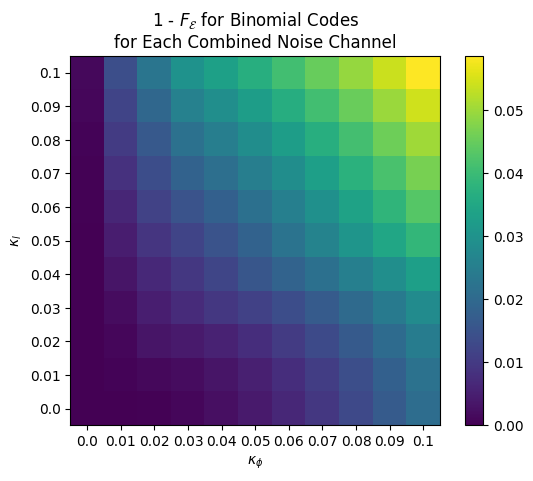

In [4]:
best_binomial_fidelities_per_region = np.max(binomial_fidelities.reshape((len(loss_noise_values), len(dephasing_noise_values), -1)), -1)

plt.figure()
plt.imshow(1 - best_binomial_fidelities_per_region, origin="lower")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("1 - $F_\\mathcal{E}$ for Binomial Codes\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar()
plt.show()

### Best Binomial Code Parameters for Each Region

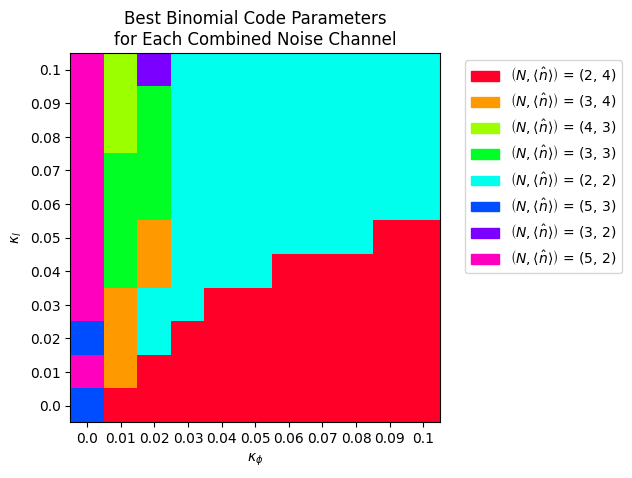

In [5]:
best_parameters = [[None for _ in dephasing_noise_values] for _ in loss_noise_values]
for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		fidelities_in_region = binomial_fidelities[i,j]
		maximizing_indices = np.unravel_index(fidelities_in_region.argmax(), fidelities_in_region.shape)
		best_parameters[i][j] = (rotation_symmetries[maximizing_indices[0]], average_photon_numbers[maximizing_indices[1]])
unique_best_parameters = list(set([parameter for parameter_list in best_parameters for parameter in parameter_list]))
parameter_to_data = {value: index for index, value in enumerate(unique_best_parameters)}
image_data = np.array([[parameter_to_data[parameter] for parameter in sublist] for sublist in best_parameters])

plt.figure()
imshow = plt.imshow(image_data, origin="lower", interpolation="none", cmap="gist_rainbow")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("Best Binomial Code Parameters\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
used_colors = [imshow.cmap(imshow.norm(value)) for value in range(len(unique_best_parameters))]
patches = [matplotlib.patches.Patch(color=used_colors[i], label=f"$\\left(N, \\langle\\hat n\\rangle\\right)$ = {unique_best_parameters[i]}") for i in range(len(unique_best_parameters))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

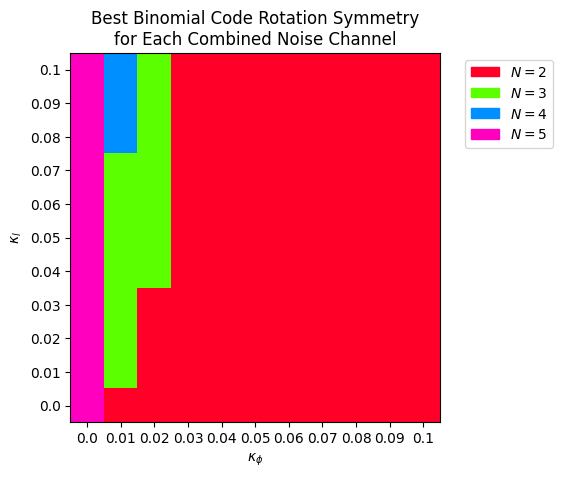

In [6]:
stripped_image_data = [[rotation_symmetry for rotation_symmetry, _ in sublist] for sublist in best_parameters]
unique_good_rotation_symmetries = list(set([rotation_symmetry for sublist in stripped_image_data for rotation_symmetry in sublist]))

plt.figure()
imshow = plt.imshow(stripped_image_data, origin="lower", interpolation="none", cmap="gist_rainbow")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("Best Binomial Code Rotation Symmetry\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
used_colors = [imshow.cmap(imshow.norm(rotation_symmetry)) for rotation_symmetry in unique_good_rotation_symmetries]
patches = [matplotlib.patches.Patch(color=used_colors[i], label=f"$N = {unique_good_rotation_symmetries[i]}$") for i in range(len(unique_good_rotation_symmetries))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

### Generate Fidelities for Two-Expanded Haar Random Codes

In [7]:
%%time

for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		for k, rotation_symmetry in enumerate(rotation_symmetries):
			for l, average_photon_number in enumerate(average_photon_numbers):
				for m in range(number_of_random_code_trials):
					dimension = (average_photon_number + 2) * rotation_symmetry
					combined_noise = noise.Noise(dimension, [("dephasing", dephasing_noise_value), ("loss", loss_noise_value)])
					random_code = code.make_two_expanded_haar_random_code(rotation_symmetry, average_photon_number, dimension)
					code_simulator.get_fidelity_of(random_code, combined_noise, True)

CPU times: user 1.26 ms, sys: 2 µs, total: 1.26 ms
Wall time: 316 µs


### Get the Best Stored Random Code Fidelities

In [8]:
random_fidelities = np.zeros((len(loss_noise_values), len(dephasing_noise_values), len(rotation_symmetries), len(average_photon_numbers)))
for i, loss_noise_value in enumerate(loss_noise_values):
	for j, dephasing_noise_value in enumerate(dephasing_noise_values):
		for k, rotation_symmetry in enumerate(rotation_symmetries):
			for l, average_photon_number in enumerate(average_photon_numbers):
					dimension = (average_photon_number + 2) * rotation_symmetry
					combined_noise = noise.Noise(dimension, [("dephasing", dephasing_noise_value), ("loss", loss_noise_value)])
					code_name = f"two-expanded-haar-random-{rotation_symmetry},{average_photon_number},{dimension}"
					random_fidelities[i,j,k,l] = code_simulator.get_known_fidelity_for(code_name, True, combined_noise, True)

### Random Code Optimal Fidelities in Each Region

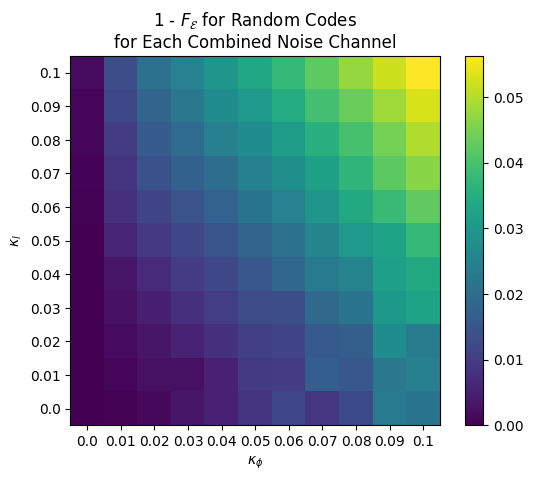

In [9]:
best_random_fidelities_per_region = np.max(random_fidelities.reshape((len(loss_noise_values), len(dephasing_noise_values), -1)), -1)

plt.figure()
plt.imshow(1 - best_random_fidelities_per_region, origin="lower")
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("1 - $F_\\mathcal{E}$ for Random Codes\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar()
plt.show()

### Best Code in Each Region

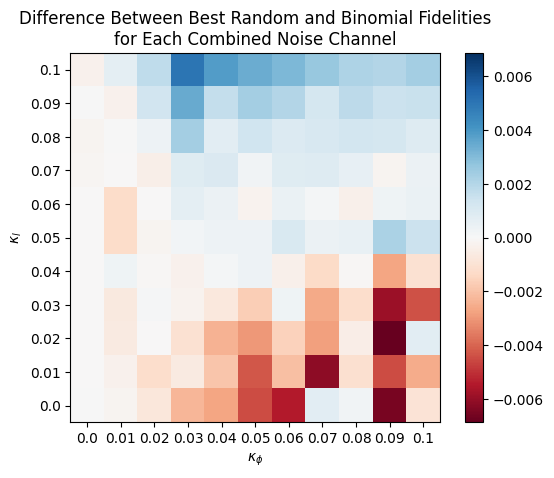

In [10]:
fidelity_difference = best_random_fidelities_per_region - best_binomial_fidelities_per_region

cmap = plt.get_cmap("RdBu")
most_extreme_fidelity_difference = max(np.max(fidelity_difference), np.max(-fidelity_difference))
normalizer = matplotlib.colors.Normalize(-most_extreme_fidelity_difference, most_extreme_fidelity_difference)

plt.figure()
plt.imshow(fidelity_difference, origin="lower", cmap=cmap, norm=normalizer)
ax = plt.gca()
ax.set_yticks(range(len(loss_noise_values)), loss_noise_values)
ax.set_xticks(range(len(dephasing_noise_values)), dephasing_noise_values)
plt.title("Difference Between Best Random and Binomial Fidelities\nfor Each Combined Noise Channel")
plt.ylabel("$\\kappa_l$")
plt.xlabel("$\\kappa_\\phi$")
plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=plt.gca())
plt.show()